# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [108]:
import sys
import hashlib
import os
import pickle
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile
from random import randint

from PIL import Image
from matplotlib.pyplot import imshow

import cv2
import csv

%matplotlib inline

import math
import tensorflow as tf
import matplotlib.pyplot as plt

print('All modules imported.')

All modules imported.


In [4]:
# Load pickled data

# TODO: fill this in based on where you saved the training and testing data
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

x_train, y_train = train['features'], train['labels']
x_test, y_test = test['features'], test['labels']

In [5]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(x_train)

# TODO: number of testing examples
n_test = len(x_test)

# TODO: what's the shape of an image?
height, width, channels = x_train[0].shape
image_shape = height * width

# TODO: how many classes are in the dataset
classes = set(y_train)
n_classes = len(classes)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 1024
Number of classes = 43


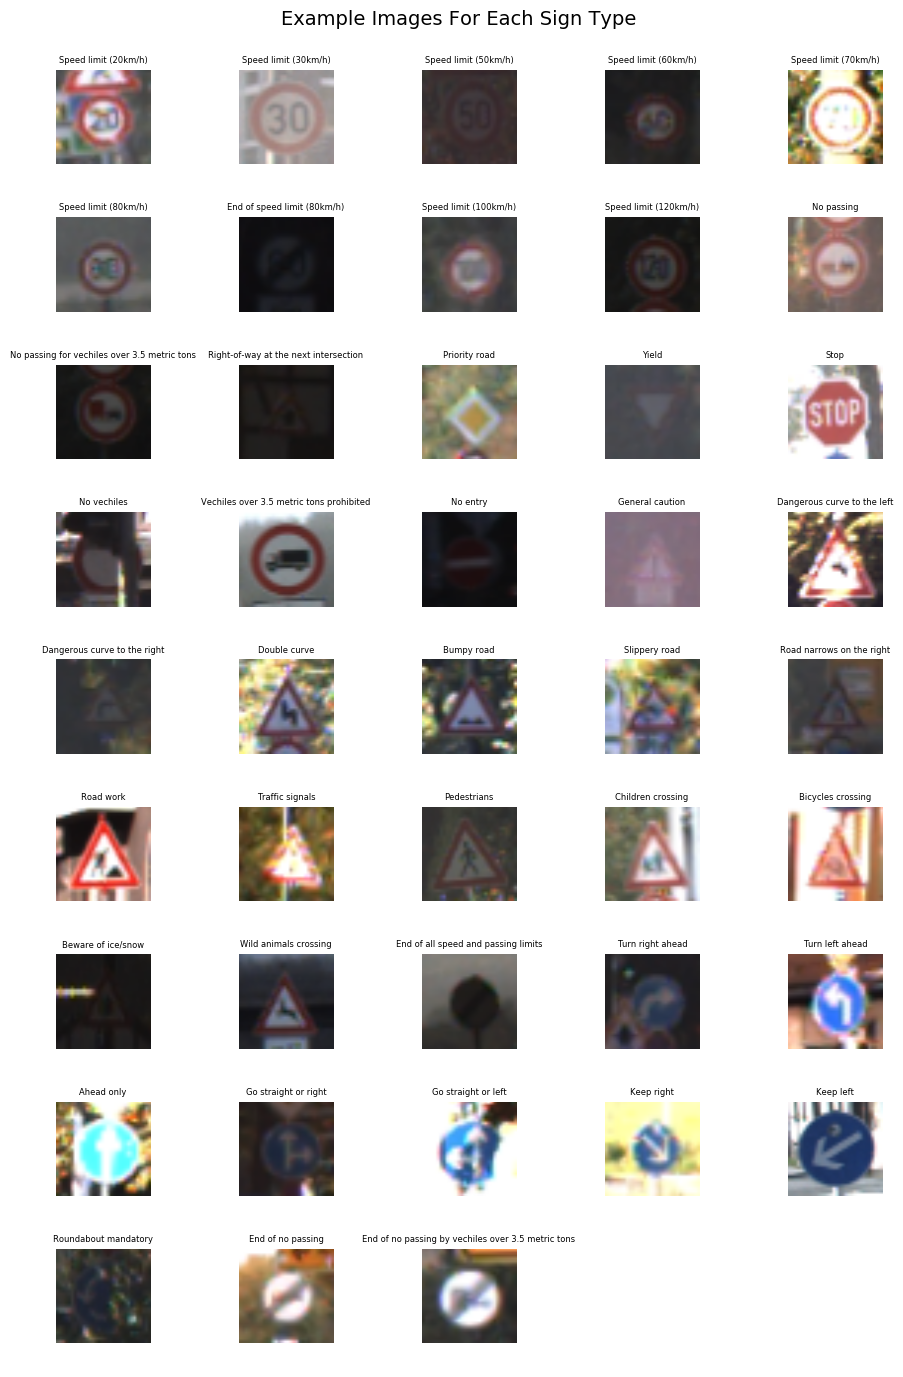

In [152]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Read signnames.csv and create a list of labels
signnames = []
with open("signnames.csv", "rt") as csvfile:
    signreader = csv.reader(csvfile, delimiter=',')
    for index, row in enumerate(signreader):
        if index == 0:
            continue
        signnames.append(row[1])

# Show an example of each class of sign with its corresponding label
current_index = 0
current_type = 0
num_columns = 5
num_rows = 9

fig, axarr = plt.subplots(num_rows, num_columns, figsize=(9, 14))
fig.suptitle("Example Images For Each Sign Type", fontsize=14)

for row in range(num_rows):
    for column in range(num_columns):
        image = axarr[row, column]
        image.axis('off')
        for index in range(current_index, len(y_train)):
            if y_train[index] == current_type:
                current_index = index
                image.imshow(x_train[current_index])
                image.set_title(signnames[current_type], fontsize=6)
                current_type += 1
                break
            
# Tight layout often produces nice results but requires the title to be spaced accordingly
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.show()


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def grayscale(img_arr):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    features = []
    for image in img_arr:
        features.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    return features

# Min-Max scaling for grayscale image data
def normalize_grayscale(img_arr):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    
    """
    features = []
    for image in img_arr:
        min_val = 0
        max_val = 255
        a = 0.1
        b = 0.9
        features.append(a + (((image - min_val) * (b - a)) / (max_val - min_val)))
    return features

def flatten_features(img_arr):
    features = []
    for image in img_arr:
        features.append(np.array(image, dtype=np.float32).flatten())
    return features

# Test Cases
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 255])),
    [0.1, 0.103137254902, 0.106274509804, 0.109411764706, 0.112549019608, 0.11568627451, 0.118823529412, 0.121960784314,
     0.125098039216, 0.128235294118, 0.13137254902, 0.9],
    decimal=3)
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 10, 20, 30, 40, 233, 244, 254,255])),
    [0.1, 0.103137254902, 0.13137254902, 0.162745098039, 0.194117647059, 0.225490196078, 0.830980392157, 0.865490196078,
     0.896862745098, 0.9])

if not is_features_normal:
    # Apply Grayscale transform and normalize
    train_features = grayscale(x_train)
    train_features = normalize_grayscale(train_features)
    #imshow(train_features[0], cmap='gray')
    train_features = flatten_features(train_features)
    test_features = grayscale(x_test)
    test_features = normalize_grayscale(test_features)
    test_features = flatten_features(test_features)
    is_features_normal = True

print('Normalize Tests Passed!')

Normalize Tests Passed!


In [7]:
if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(y_train)
    train_labels = encoder.transform(y_train)
    test_labels = encoder.transform(y_test)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    is_labels_encod = True

print('Labels One-Hot Encoded')
#print("train_labels[0]={}".format(train_labels[0]))

Labels One-Hot Encoded


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

It took me some time to tease apart the raw pickled data.  As a python noob, I learned about this common serialization while examining the array structure for the image data.  Using the set() class, I matched classes with example images to visualize the road signs in the training data.

Next I applied a grayscale transform and normalized the min-max scaling for ease of computation.

After that, I applied One-Hot Encoding to the label data and changed the type to float32


In [8]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# ToDo: Set the features and labels tensors
features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

# ToDo: Set the weights and biases tensors
weights = tf.Variable(tf.truncated_normal((image_shape, n_classes)))
biases = tf.Variable(tf.zeros(n_classes))

### DON'T MODIFY ANYTHING BELOW ###

#Test Cases
from tensorflow.python.ops.variables import Variable

assert features._op.name.startswith('Placeholder'), 'features must be a placeholder'
assert labels._op.name.startswith('Placeholder'), 'labels must be a placeholder'
assert isinstance(weights, Variable), 'weights must be a TensorFlow variable'
assert isinstance(biases, Variable), 'biases must be a TensorFlow variable'

assert features._shape == None or (\
    features._shape.dims[0].value is None and\
    features._shape.dims[1].value in [None, image_shape]), 'The shape of features is incorrect'
assert labels._shape in [None, n_classes], 'The shape of labels is incorrect'
assert weights._variable._shape == (image_shape, n_classes), 'The shape of weights is incorrect'
assert biases._variable._shape == (n_classes), 'The shape of biases is incorrect'

assert features._dtype == tf.float32, 'features must be type float32'
assert labels._dtype == tf.float32, 'labels must be type float32'

# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy
cross_entropy = -tf.reduce_sum(labels * tf.log(tf.clip_by_value(prediction, 1e-10, 1.0)), reduction_indices=[1])

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
init = tf.initialize_all_variables()

# Test Cases
with tf.Session() as session:
    session.run(init)
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    session.run(loss, feed_dict=test_feed_dict)
    biases_data = session.run(biases)

assert not np.count_nonzero(biases_data), 'biases must be zeros'

print('Tests Passed!')

Tests Passed!


In [10]:
# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')

Accuracy function created.


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Epoch 100/100: 100%|██████████| 745/745 [00:05<00:00, 130.60batches/s]


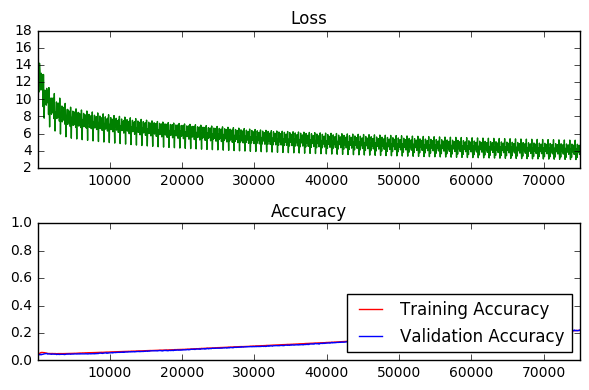

Validation accuracy at 0.222335547208786


In [13]:
### Train your model here.
### Feel free to use as many code cells as needed.
epochs = 100
batch_size = 50
learning_rate = 0.001

### DON'T MODIFY ANYTHING BELOW ###
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), file=sys.stdout, unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run([optimizer, loss], feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
        
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

In [153]:
# ToDo: Set the epochs, batch_size, and learning_rate
epochs = 100
batch_size = 50
learning_rate = 0.001

### DON'T MODIFY ANYTHING BELOW ###
# The accuracy measured against the test set
test_accuracy = 0.0

with tf.Session() as session:
    
    session.run(init)
    batch_count = int(math.ceil(len(train_features) / batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer
            _ = session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)


assert test_accuracy >= 0.80, 'Test accuracy at {}, should be equal to or greater than 0.80'.format(test_accuracy)
print('Nice Job! Test Accuracy is {}'.format(test_accuracy))

Epoch 100/100: 100%|██████████| 745/745 [00:01<00:00, 649.90batches/s]


Nice Job! Test Accuracy is 0.8013460040092468


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.